In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

# 저장된 모델 파일을 로드
with open('/content/drive/MyDrive/설문조사 AI 용 데이터/2. 새로운_모델_11-14 완성/survey_ai_new_MF_model.md', 'rb') as file:
    loaded_model = pickle.load(file)

print(f"K: {loaded_model.K}, iter : {loaded_model.iterations}")

K: 10, iter : 260


#새 데이터 MF 클래스

In [ ]:
# New MF class for training & testing
class NEW_MF():
    ###학습에 필요한 변수들 초기화작업###
    #ratings:평점. 사용자-아이템 평점 행렬이 들어옴
    #k:잠재요인(Latent Factor) 수 : p와q 행렬로 나뉘어질 때 각 행렬이 동일하게 가질 잠재요인 수
    #alpha:학습률 (Learning Rate), beta:정규화 개수, iterations:반복 횟수, verbose:중간출력옵션 - 따로 정해주는
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)

        # user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성 과정
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings): #enumerate(ratings)하면 - 0:첫번째 열이름 1:두번째열이름 반환됨
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)

        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T): #T 해서 사용자를index에서 column으로 만든 다음 위와 똑같이 진행함
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        # num_users : 사용자 수, num_items(아이템 수)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    # 현재의 P와 Q를 가지고 Root Mean Squared Error (RMSE) 계산
    def rmse(self):
        # 평점이 있는(0이 아닌) 요소의 인덱스
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            # 사용자 x, 아이템 y에 대해서 평점 예측치를 get_prediction()함수를 사용하여 계산
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            # 계산된 평점과 실제 값간의 오차를 errors리스트에 추가
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        # RMSE를 계산하여 반환
        return np.sqrt(np.mean(self.errors**2))

    #사용자i, 아이템j에 대해서 평점 예측하기
    def get_prediction(self, i, j):
        #전체 편향 + 사용자 i에 대한 편향 + 아이템 j에 대한 편향 + """잠재 요인 벡터 내적"""
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent - 확률적 경사하강법 to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j) #예측
            e = (r - prediction) #e 오차 r 실제

            #개별 편향 업데이트
            #alpha : learning rate, 학습률. 반복마다 얼마나 큰 폭으로 업데이트할지에 대한 값
            #beta : regulation term, 정규화 계수. 편향이 과도하게 커지는 것을 방지하려 있음.
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

##### >>>>> (3)
    ### 분리된 test set을 넘겨받아 클래스 내부의 test_set을 만드는 함수 ###
    #.set_test() 부를때 넣어줄 테스트 데이터는 user_id, movid_Id, rating 세 열을 가진 데이터라
    #user_id, movie_id를 index로 바꿔준 값과 rating까지 가지는 데이터를 test_set으로 새로 만듦
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            # 현재 사용자, 아이템의 인덱스를 user_id_index에서 받아온다. (__init__에서 만듦)
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            # 현재 사용자-아이템의 평점
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])

            # R을 사용해서 MF 모델을 학습하기 떄문에 test_set의 R을 제거
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        # test set에 있는 각각의 (사용자, 아이템, 평점)에 대해서 RMSE를 구한다.
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        #사용자-k 행렬 P와 아이템-k 행렬 Q 정의
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        #편향 초기화. 학습이 진행되면서 각 사용자, 아이템마다의 편향값을 저장할 변수임.
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        #전체 평균 편향 : R에서 0이 아닌 모든 것들의 평균
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()       #train rsme
            rmse2 = self.test_rmse()  #test rsme
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 20 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

#최적의 k 값 구하기


In [ ]:
#데이터 불러오기
#df_original = pd.read_csv("/content/drive/MyDrive/설문조사 AI 용 데이터/test_all_shelves.csv", encoding='utf-8-sig', dtype = {"ISBN" : 'str'})
df_original = pd.read_csv("/content/drive/MyDrive/설문조사 AI 용 데이터/4. 11_14 isbn 최신꺼 쓰기 모델/10만행_데이터_isbn_갱신.csv", encoding='utf-8-sig', dtype = {"ISBN" : 'str'})
df = df_original.copy()
df.drop_duplicates(subset = ['user_id','isbn'], keep='first').reset_index(drop=True)

#데이터 전처리
df_preprocessed = df[['user_id','isbn','rating']]
TRAIN_SIZE = 0.75
cutoff = int(TRAIN_SIZE  * len(df_preprocessed))
df_train = df_preprocessed.iloc[:cutoff]
df_test = df_preprocessed.iloc[cutoff:]

In [ ]:
#최적의 k값 구하기
for k in range(10, 201, 10):
  print("K : ",k)
  R_temp = df_preprocessed.pivot(index='user_id', columns='isbn', values='rating').fillna(0)
  mf = NEW_MF(R_temp, K=k, alpha = 0.001, beta = 0.02, iterations = 600, verbose=True)
  test_set = mf.set_test(df_test)
  result = mf.test()
  print("\n")

K :  10
Iteration: 20 ; Train RMSE = 1.3779 ; Test RMSE = 1.4271
Iteration: 40 ; Train RMSE = 1.3642 ; Test RMSE = 1.4371
Iteration: 60 ; Train RMSE = 1.3465 ; Test RMSE = 1.4370
Iteration: 80 ; Train RMSE = 1.3122 ; Test RMSE = 1.4210
Iteration: 100 ; Train RMSE = 1.2452 ; Test RMSE = 1.3784
Iteration: 120 ; Train RMSE = 1.1359 ; Test RMSE = 1.3011
Iteration: 140 ; Train RMSE = 1.0032 ; Test RMSE = 1.2023
Iteration: 160 ; Train RMSE = 0.8856 ; Test RMSE = 1.1130
Iteration: 180 ; Train RMSE = 0.8018 ; Test RMSE = 1.0511
Iteration: 200 ; Train RMSE = 0.7464 ; Test RMSE = 1.0146
Iteration: 220 ; Train RMSE = 0.7086 ; Test RMSE = 0.9949
Iteration: 240 ; Train RMSE = 0.6812 ; Test RMSE = 0.9853
Iteration: 260 ; Train RMSE = 0.6600 ; Test RMSE = 0.9816
Iteration: 280 ; Train RMSE = 0.6428 ; Test RMSE = 0.9813
Iteration: 300 ; Train RMSE = 0.6286 ; Test RMSE = 0.9830
Iteration: 320 ; Train RMSE = 0.6163 ; Test RMSE = 0.9858
Iteration: 340 ; Train RMSE = 0.6057 ; Test RMSE = 0.9894
Iteration:

KeyboardInterrupt: 

출력

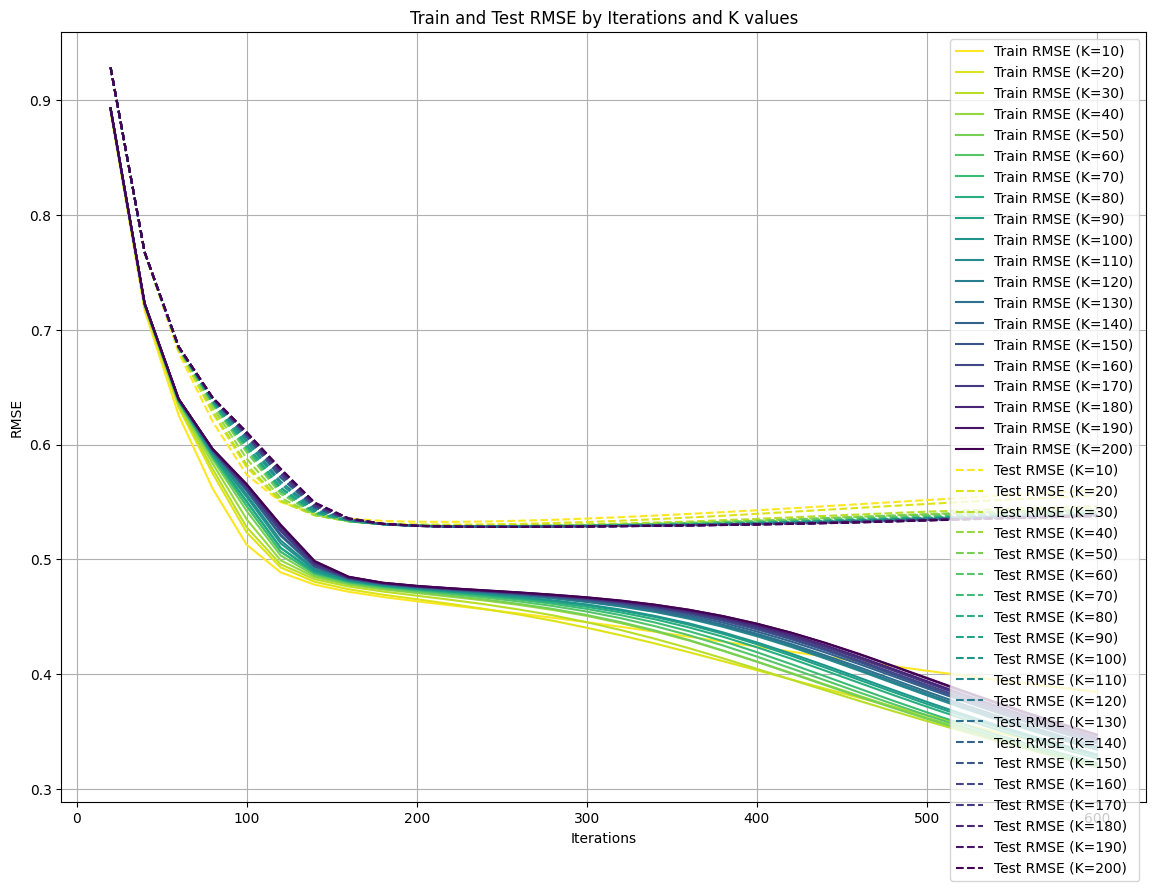

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 초기화
data = {}
k_values = []

# txt 파일 읽기
with open('/content/drive/MyDrive/설문조사 AI 용 데이터/3. 새로운_모델_11_15_유저정보 일관/새로운 모델 유저정보 일관 - 학습결과.txt', 'r') as file:
    current_k = None
    for line in file:
        line = line.strip()
        if line.startswith("K :"):
            # K 값을 추출하여 정수로 저장
            current_k = int(line.split(':')[1].strip())
            data[current_k] = {'iterations': [], 'train_rmse': [], 'test_rmse': []}
            k_values.append(current_k)
        elif line.startswith("Iteration:"):
            # Iteration과 RMSE 값을 추출
            parts = line.split(';')
            iteration = int(parts[0].split(':')[1].strip())
            train_rmse = float(parts[1].split('=')[1].strip())
            test_rmse = float(parts[2].split('=')[1].strip())

            # 데이터 저장
            data[current_k]['iterations'].append(iteration)
            data[current_k]['train_rmse'].append(train_rmse)
            data[current_k]['test_rmse'].append(test_rmse)

# 그래프 그리기
colors = plt.cm.viridis_r(np.linspace(0, 1, len(k_values)))
plt.figure(figsize=(14, 10))

# Train RMSE
for i, k in enumerate(k_values):
    plt.plot(data[k]['iterations'], data[k]['train_rmse'], label=f'Train RMSE (K={k})', color=colors[i], linestyle='-')

# Test RMSE
for i, k in enumerate(k_values):
    plt.plot(data[k]['iterations'], data[k]['test_rmse'], label=f'Test RMSE (K={k})', color=colors[i], linestyle='--')

# 레이블 설정
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE by Iterations and K values')
plt.legend()
plt.grid(True)
plt.show()


#메인 학습

In [ ]:
#데이터 불러오기
#df_original = pd.read_csv("/content/drive/MyDrive/설문조사 AI 용 데이터/test_all_shelves.csv", encoding='utf-8-sig', dtype = {"ISBN" : 'str'})
df_original = pd.read_csv("/content/drive/MyDrive/설문조사 AI 용 데이터/4. 11_14 isbn 최신꺼 쓰기 모델/10만행_데이터_isbn_갱신.csv", encoding='utf-8-sig', dtype = {"ISBN" : 'str'})
df = df_original.copy()

#데이터 전처리
df_preprocessed = df[['user_id','isbn','rating']]
TRAIN_SIZE = 0.75
cutoff = int(TRAIN_SIZE  * len(df_preprocessed))
df_train = df_preprocessed.iloc[:cutoff]
df_test = df_preprocessed.iloc[cutoff:]

In [ ]:
R_temp = df_preprocessed.pivot(index='user_id', columns='isbn', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha = 0.001, beta = 0.02, iterations = 260, verbose=True)
test_set = mf.set_test(df_test)
result = mf.test()

Iteration: 20 ; Train RMSE = 1.3779 ; Test RMSE = 1.4269
Iteration: 40 ; Train RMSE = 1.3644 ; Test RMSE = 1.4370
Iteration: 60 ; Train RMSE = 1.3472 ; Test RMSE = 1.4368
Iteration: 80 ; Train RMSE = 1.3138 ; Test RMSE = 1.4210
Iteration: 100 ; Train RMSE = 1.2481 ; Test RMSE = 1.3786
Iteration: 120 ; Train RMSE = 1.1384 ; Test RMSE = 1.3005
Iteration: 140 ; Train RMSE = 1.0006 ; Test RMSE = 1.1981
Iteration: 160 ; Train RMSE = 0.8764 ; Test RMSE = 1.1041
Iteration: 180 ; Train RMSE = 0.7898 ; Test RMSE = 1.0400
Iteration: 200 ; Train RMSE = 0.7348 ; Test RMSE = 1.0034
Iteration: 220 ; Train RMSE = 0.6984 ; Test RMSE = 0.9844
Iteration: 240 ; Train RMSE = 0.6720 ; Test RMSE = 0.9753
Iteration: 260 ; Train RMSE = 0.6515 ; Test RMSE = 0.9717


In [ ]:
#모델저장
with open('/content/drive/MyDrive/설문조사 AI 용 데이터/4. 11_14 isbn 최신꺼 쓰기 모델/survey_ai_isbn_correction.md', 'wb') as file:
    pickle.dump(mf, file)


#추론

In [ ]:
#genre = ['소설','시','만화','역사','문학','고전','요리/살림','에세이','여행','과학']
new_age = 22
new_sex = 'M'
new_genre = '만화'

In [ ]:
df_original = pd.read_csv("/content/drive/MyDrive/설문조사 AI 용 데이터/4. 11_14 isbn 최신꺼 쓰기 모델/10만행_데이터_isbn_갱신.csv", encoding='utf-8-sig', dtype = {"ISBN" : 'str'})
df = df_original.copy()

# 저장된 모델 파일을 로드
with open('/content/drive/MyDrive/설문조사 AI 용 데이터/4. 11_14 isbn 최신꺼 쓰기 모델/survey_ai_isbn_correction.md', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
#나이 성별 장르
pos = df[(df['age'] == new_age) & (df['sex'] == new_sex) & (df['fav_genre'] == new_genre)]

jump = -1
while pos.shape[0] == 0:
  new_age += jump
  pos = df[(df['age'] == new_age) & (df['sex'] == new_sex) & (df['fav_genre'] == new_genre)]

  #없으면 검색하는 나이 변경
  jump = jump - 1 if jump < 0 else jump + 1
  jump = -jump
  #검색 실패시 user_id랜덤에 break
  if abs(jump) > 100:
    pos = np.random.randint(1,900)
    break

#pos중 랜덤 행의 user_id
user_id_key = pos.sample(1)['user_id'].values[0]
print("user_id : ", user_id_key)

M = loaded_model.full_prediction()
M.shape

col = list(loaded_model.index_item_id.values())
val = M[loaded_model.user_id_index[user_id_key], : ]
res = pd.DataFrame(columns=col, data=val.reshape(1,-1))

res = res.T.sort_values(by=0, ascending=False)
res_index = res.index[0:10]
res_values = res.values[0:10]

print(res_index, res_values)

user_id :  275
Index([9791170628118, 9791127549183, 9791136772473, 9791136771667,
       9788979293807, 9791170628736, 9791169798938, 9791171241132,
       9791167771285, 9791138032414],
      dtype='int64') [[5.08847592]
 [4.92225209]
 [4.83312948]
 [4.799014  ]
 [4.73707731]
 [4.69762503]
 [4.65542658]
 [4.63342162]
 [4.59883408]
 [4.5573626 ]]


In [ ]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)

        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)

        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        # RMSE를 계산하여 반환
        return np.sqrt(np.mean(self.errors**2))

    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j) #예측
            e = (r - prediction) #e 오차 r 실제


            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

##### >>>>> (3)
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])

            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    def test(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()       #train rsme
            rmse2 = self.test_rmse()  #test rsme
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 20 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

In [ ]:
openai.api_key =